In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [2]:
data = pd.read_csv('airline_passengers.txt')
print(data.head())
print(data.tail())
print("\n",data.dtypes)
data.describe()

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121
       Month  Passengers
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432

 Month         object
Passengers     int64
dtype: object


,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [3]:
from datetime import datetime
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.index
type(data)

pandas.core.frame.DataFrame

0


pandas.core.series.Series

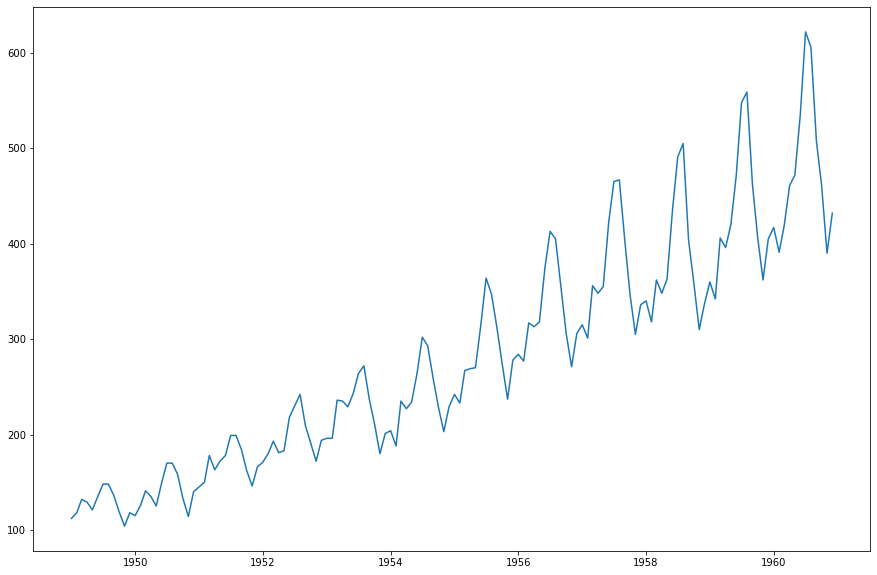

In [4]:
ts = data['Passengers']
print(ts.isnull().sum())
print(plt.plot(ts))
type(ts)

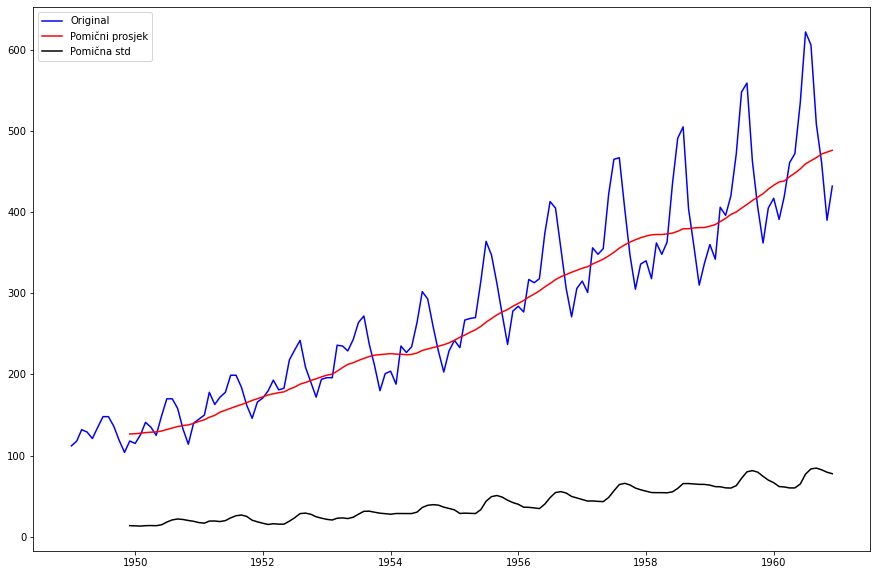

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Pomični prosjek')
    std = plt.plot(rolstd, color='black', label = 'Pomična std')
    plt.legend(loc='best')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
test_stationarity(ts)

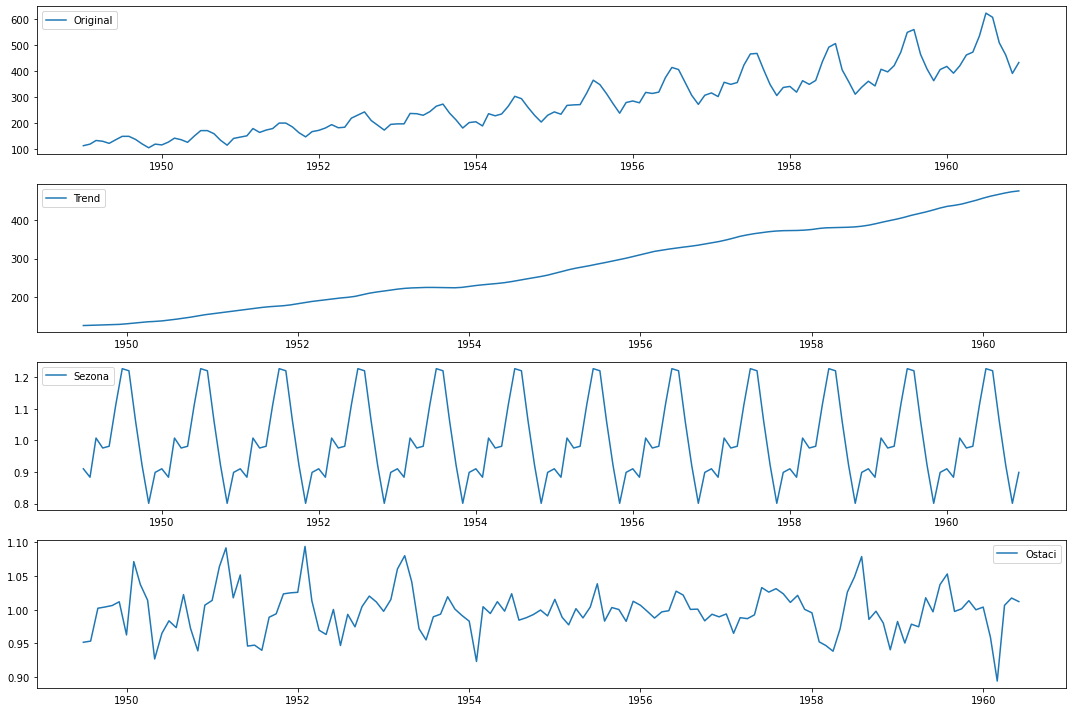

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts,model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Sezona')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Ostaci')
plt.legend(loc='best')
plt.tight_layout()

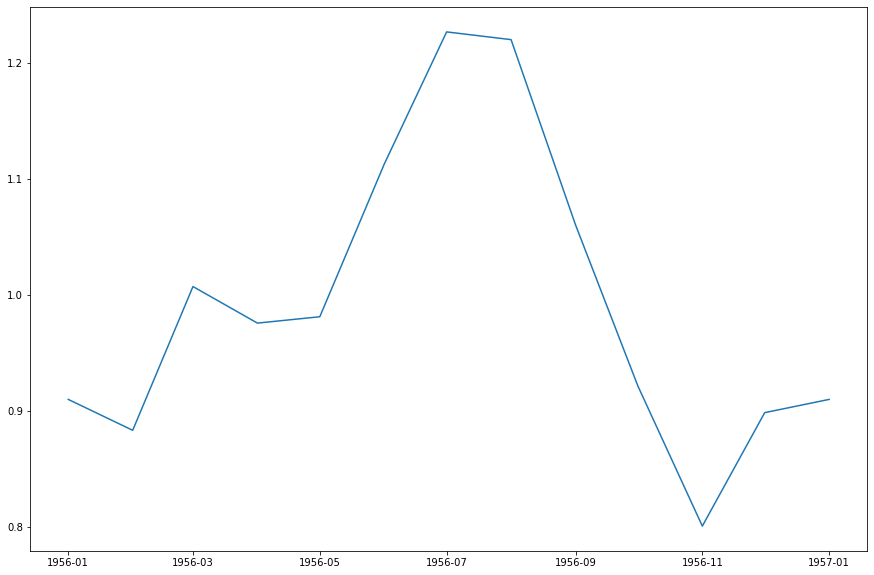

In [7]:
plt.plot(seasonal['1956':'1957-01-01'])

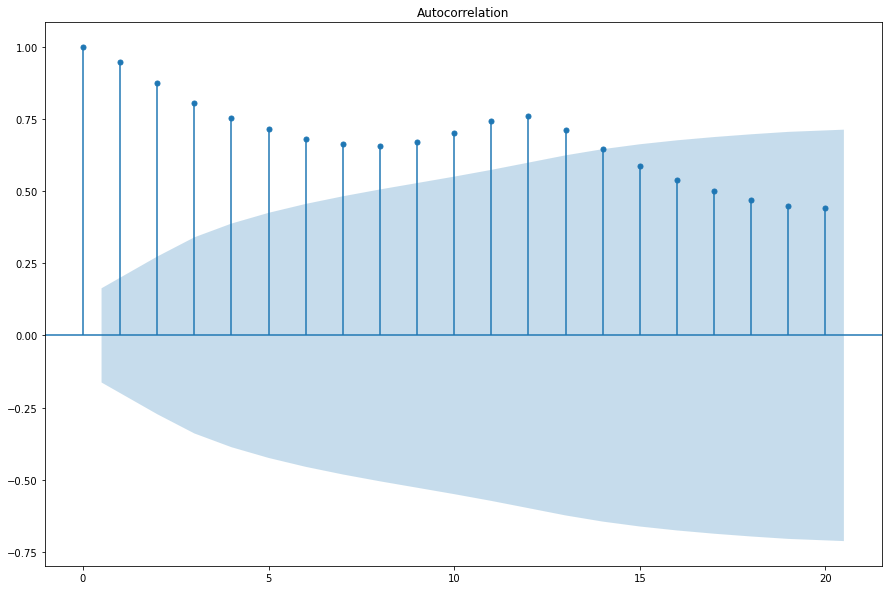

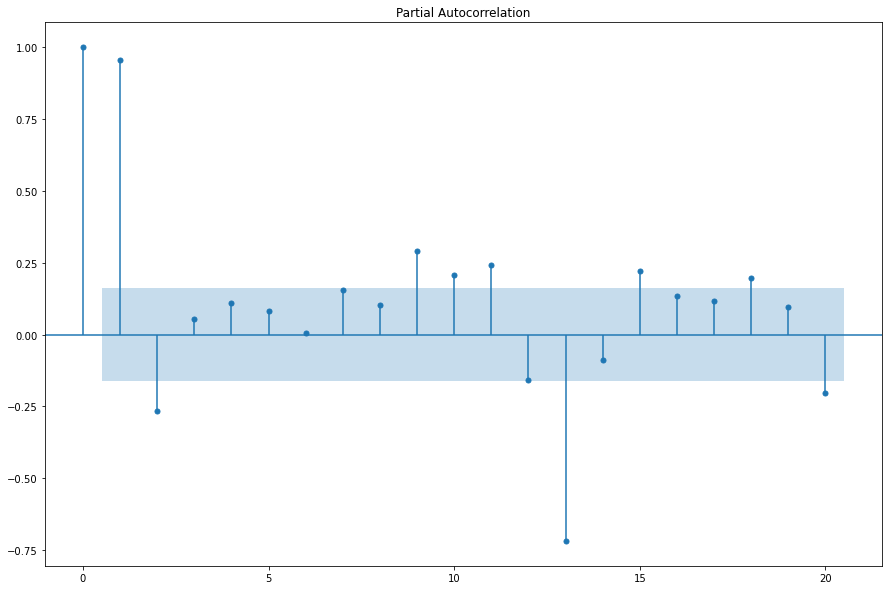

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts,lags=20)
plot_pacf(ts, lags =20)
plt.show()

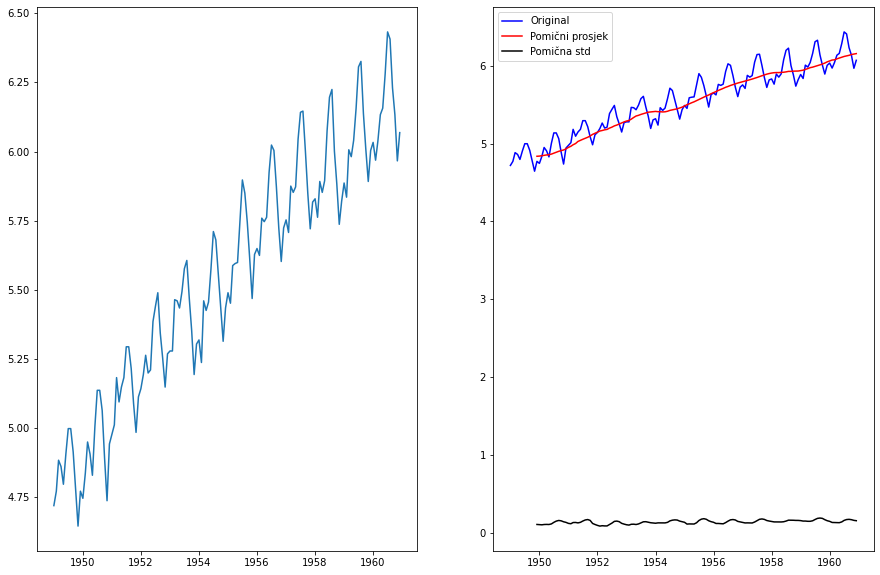

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
ts_log = np.log(ts)
plt.subplot(121)
plt.plot(ts_log)
plt.subplot(122)
test_stationarity(ts_log)

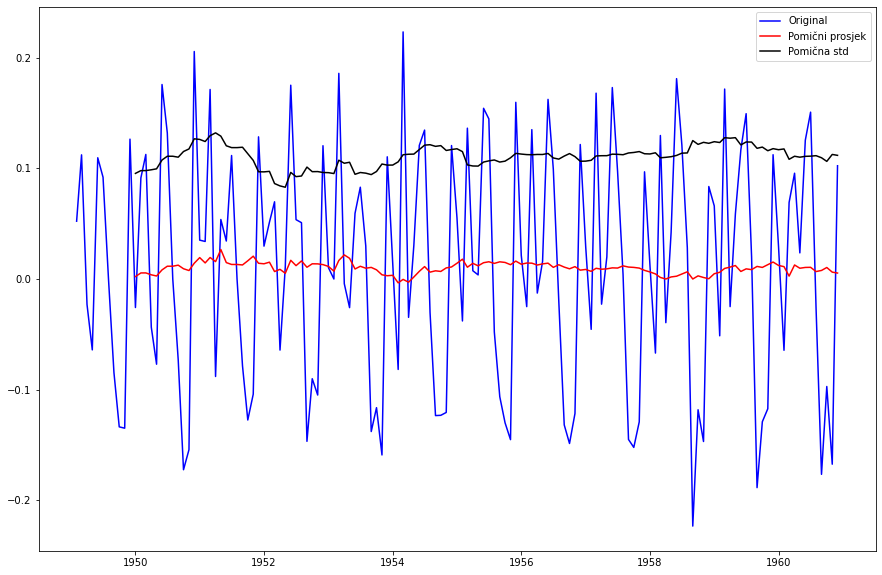

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [10]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [11]:
train, test = np.split(ts, [int(.7 *len(ts))])
validate, test =np.split(test, [int(.5 *len(test))])
print(len(validate))
print(train.tail())
print(validate)

22
Month
1956-12-01    306
1957-01-01    315
1957-02-01    301
1957-03-01    356
1957-04-01    348
Name: Passengers, dtype: int64
Month
1957-05-01    355
1957-06-01    422
1957-07-01    465
1957-08-01    467
1957-09-01    404
1957-10-01    347
1957-11-01    305
1957-12-01    336
1958-01-01    340
1958-02-01    318
1958-03-01    362
1958-04-01    348
1958-05-01    363
1958-06-01    435
1958-07-01    491
1958-08-01    505
1958-09-01    404
1958-10-01    359
1958-11-01    310
1958-12-01    337
1959-01-01    360
1959-02-01    342
Name: Passengers, dtype: int64


C:\Users\Fran\.conda\envs\general\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



Greška validate:21.630805836838835

Greška test:65.294897630088


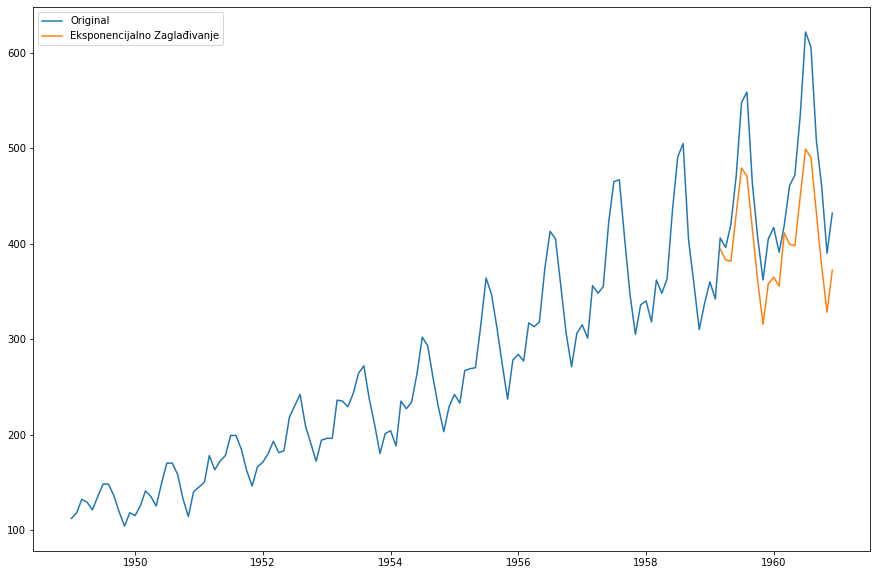

In [12]:
#Holt Winter Eksponencijalno Zaglađivanje
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_ES = ExponentialSmoothing(train, trend="add", seasonal='mul',damped=True, seasonal_periods=12)
model_fit_ES = model_ES.fit()
prediction_ES=model_fit_ES.predict(len(train),len(train)+len(validate)-1)
print("\nGreška validate:" + str(sqrt(mean_squared_error(validate, prediction_ES))))
prediction_ES=model_fit_ES.predict(len(train)+len(validate),len(ts)-1)
print("\nGreška test:" + str(sqrt(mean_squared_error(test, prediction_ES))))
plt.plot(ts, label='Original')
plt.plot(prediction_ES,label='Eksponencijalno Zaglađivanje')
plt.legend(loc='best')
plt.show()

C:\Users\Fran\.conda\envs\general\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Fran\.conda\envs\general\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Fran\.conda\envs\general\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



Greška validate:21.28846326896479

Greška test:18.943681498508663


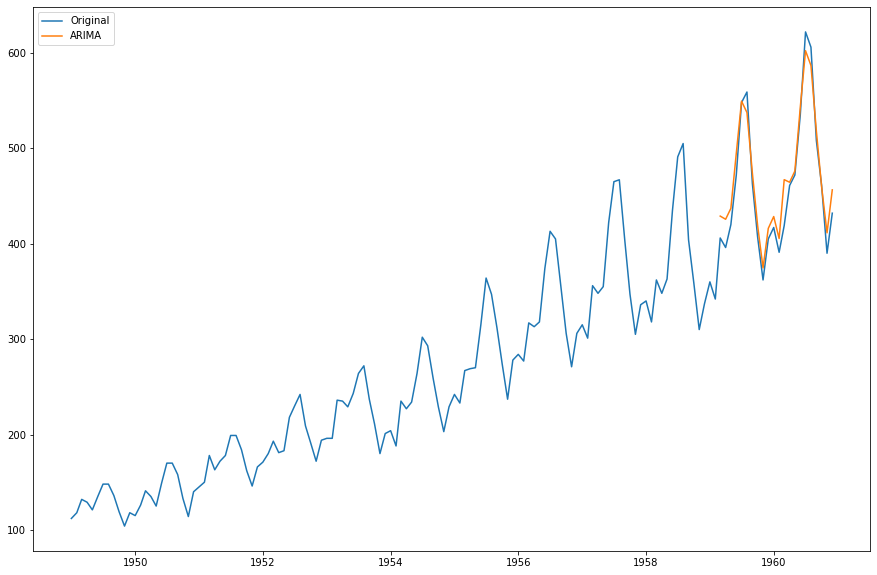

In [13]:
#SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_ARIMA = SARIMAX(train, order=(11, 2, 3), seasonal_order=(2, 2, 4, 12))
model_fit_ARIMA = model_ARIMA.fit(disp=False)
prediction_ARIMA=model_fit_ARIMA.predict(len(train),len(train)+len(validate)-1)
print("\nGreška validate:" + str(sqrt(mean_squared_error(validate, prediction_ARIMA))))
prediction_ARIMA=model_fit_ARIMA.predict(len(train)+len(validate),len(ts)-1)
print("\nGreška test:" + str(sqrt(mean_squared_error(test, prediction_ARIMA))))
plt.plot(ts, label='Original')
plt.plot(prediction_ARIMA,label='ARIMA')
plt.legend(loc='best')
plt.show()

In [14]:
# MLP priprema
from numpy import array
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

n_steps_in, n_steps_out = 6, 22
X, y = split_sequence(train, n_steps_in, n_steps_out)
for i in range(len(X)):
    print(i,X[i], y[i])

0 [112 118 132 129 121 135] [148 148 136 119 104 118 115 126 141 135 125 149 170 170 158 133 114 140
 145 150 178 163]
1 [118 132 129 121 135 148] [148 136 119 104 118 115 126 141 135 125 149 170 170 158 133 114 140 145
 150 178 163 172]
2 [132 129 121 135 148 148] [136 119 104 118 115 126 141 135 125 149 170 170 158 133 114 140 145 150
 178 163 172 178]
3 [129 121 135 148 148 136] [119 104 118 115 126 141 135 125 149 170 170 158 133 114 140 145 150 178
 163 172 178 199]
4 [121 135 148 148 136 119] [104 118 115 126 141 135 125 149 170 170 158 133 114 140 145 150 178 163
 172 178 199 199]
5 [135 148 148 136 119 104] [118 115 126 141 135 125 149 170 170 158 133 114 140 145 150 178 163 172
 178 199 199 184]
6 [148 148 136 119 104 118] [115 126 141 135 125 149 170 170 158 133 114 140 145 150 178 163 172 178
 199 199 184 162]
7 [148 136 119 104 118 115] [126 141 135 125 149 170 170 158 133 114 140 145 150 178 163 172 178 199
 199 184 162 146]
8 [136 119 104 118 115 126] [141 135 125 149 170

Using TensorFlow backend.



Month
1956-11-01    271
1956-12-01    306
1957-01-01    315
1957-02-01    301
1957-03-01    356
1957-04-01    348
Name: Passengers, dtype: int64

Greška validate:26.95113423148711

Greška test:30.571823034231432


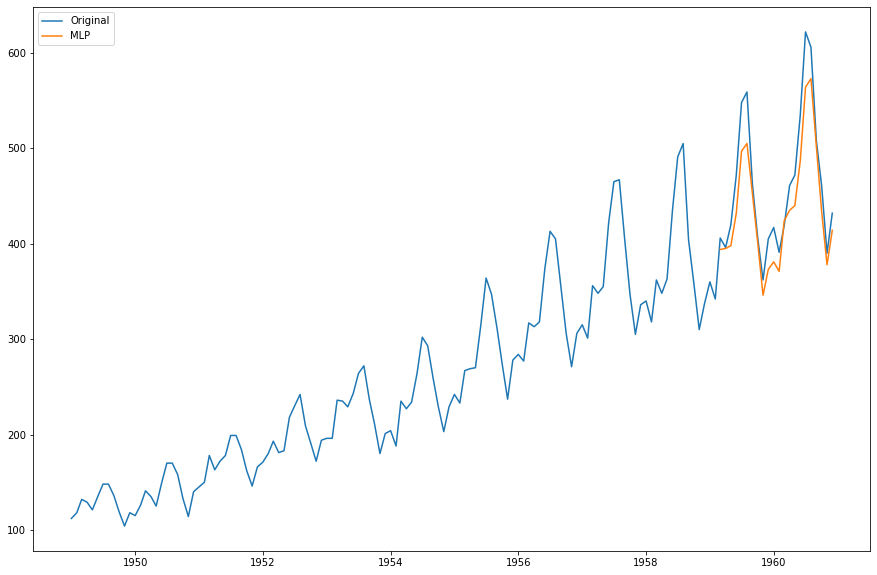

In [15]:
# MLP
from keras.models import Sequential
from keras.layers import Dense
model_MLP = Sequential()
model_MLP.add(Dense(200, activation='relu', input_dim=n_steps_in))
model_MLP.add(Dense(200, activation='relu'))
model_MLP.add(Dense(200, activation='relu'))
model_MLP.add(Dense(n_steps_out))
model_MLP.compile(optimizer='adam', loss='mse')
model_MLP.fit(X, y, epochs=3000, verbose=0)
# validacija
x_input = array(train[list(enumerate(train))[-n_steps_in][0]:])
print(train[list(enumerate(train))[-n_steps_in][0]:])
x_input = x_input.reshape((1, n_steps_in))
yhat = model_MLP.predict(x_input, verbose=0)
prediction_MLP=test.copy()
j=0
for i,broj in enumerate(prediction_MLP):
    prediction_MLP[i]=yhat[0][j]
    j+=1
print("\nGreška validate:" + str(sqrt(mean_squared_error(validate, prediction_MLP))))
#testiranje
x_input = array(validate[list(enumerate(validate))[-n_steps_in][0]:])
x_input = x_input.reshape((1, n_steps_in))
yhat = model_MLP.predict(x_input, verbose=0)
prediction_MLP=test.copy()
j=0
for i,broj in enumerate(prediction_MLP):
    prediction_MLP[i]=yhat[0][j]
    j+=1
print("\nGreška test:" + str(sqrt(mean_squared_error(test, prediction_MLP))))
plt.plot(ts, label='Original')
plt.plot(prediction_MLP,label='MLP')
plt.legend(loc='best')
plt.show()

In [16]:
#LSTM priprema
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
np.random.seed(9)
ts_scaled=array(ts[:])
ts_scaled=ts_scaled.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts_scaled)
train_scaled, test_scaled = np.split(ts_scaled, [int(.7 *len(ts_scaled))])
validate_scaled, test_scaled =np.split(test_scaled, [int(.5 *len(test_scaled))])
look_back = 1
trainX, trainY = create_dataset(train_scaled, look_back)
validateX, validateY = create_dataset(validate_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validateX = np.reshape(validateX, (validateX.shape[0], 1, validateX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


Greška validate:44.723354606474246

Greška test:55.38374708399957


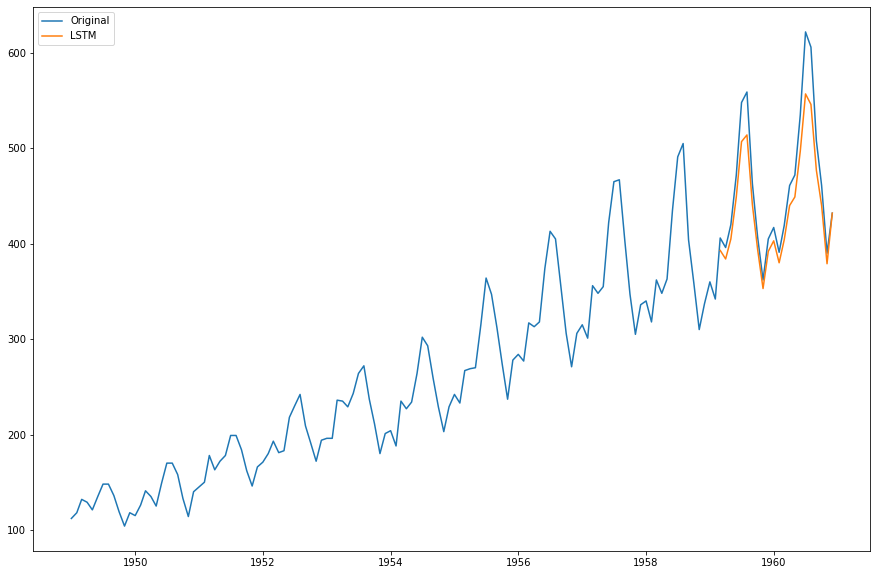

In [17]:
#LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
predict_LSTM = model.predict(validateX)
predict_LSTM = scaler.inverse_transform(predict_LSTM)
validateY = scaler.inverse_transform([validateY])
print("\nGreška validate:" + str(sqrt(mean_squared_error(validateY[0], predict_LSTM[:,0]))))
predict_LSTM = model.predict(testX)
predict_LSTM = scaler.inverse_transform(predict_LSTM)
testY = scaler.inverse_transform([testY])
print("\nGreška test:" + str(sqrt(mean_squared_error(testY[0], predict_LSTM[:,0]))))
predict_LSTM=predict_LSTM.reshape(1,-1)[0]
temp_predict=predict_LSTM[:]
predict_LSTM=test[:]
j=0
for i,v in enumerate(predict_LSTM):
    if j>=len(temp_predict):break
    predict_LSTM[i]=temp_predict[j]
    j+=1
plt.plot(ts, label='Original')
plt.plot(predict_LSTM,label='LSTM')
plt.legend(loc='best')
plt.show()